## Covariates File

In [1]:
#first we need to extract the proper IDs of Europeans 

input_file = "/home/mikekaz/projects/rrg-vmooser/mikekaz/CLSA/Ancestry/FINAL/HGDP_1KG_ancestry_inference/output/eur_individs.txt"
output_file = "/lustre06/project/6061810/mikekaz/CLSA/QC/EUR_ID_Regenie.txt"

with open(input_file, "r") as infile, open(output_file, "w") as outfile:
    for line in infile:
        parts = line.strip().split("_")
        outfile.write(parts[0] + "\n")


In [2]:
import pandas as pd


#you can only load the columns you want to be faster
file_path = "/lustre06/project/6060121/CLSA_PheWeb_shared/Original/23ME002_UdeM_SGTaliun_Baseline/23ME002_UdeM_SGTaliun_Baseline_CoPv7_Qx_PA_BS.csv"
df = pd.read_csv(file_path, low_memory=False, usecols=["SEX_ASK_COM","AGE_NMBR_COM","ADM_GWAS3_COM"],dtype={"SEX_ASK_COM":str, "AGE_NMBR_COM":int, "ADM_GWAS3_COM":str})

# Read the list of IDs of interest from the text file
with open("EUR_ID_Regenie.txt", "r") as f:
    id_list = f.read().splitlines()

# Filter the dataframe to only include the IDs of interest
df = df[df["ADM_GWAS3_COM"].isin(id_list)][["ADM_GWAS3_COM", "SEX_ASK_COM","AGE_NMBR_COM"]].copy()

# Create a new dataframe with the relevant columns
Cov_Regenie = pd.DataFrame({
    "FID": df["ADM_GWAS3_COM"].values,
    "IID": df["ADM_GWAS3_COM"].values,
    "sex": df["SEX_ASK_COM"].values,
    "age": df["AGE_NMBR_COM"].values,
    "age_squared": df["AGE_NMBR_COM"].values ** 2
})

In [3]:
# adding batch number for each sample

batch_info_df = pd.read_csv("/lustre06/project/6060121/CLSA_PheWeb_shared/Original/Genomics3_clsa/clsa_sqc_v3.txt", sep=" ", usecols=["ADM_GWAS_COM", "batch"], dtype={"ADM_GWAS_COM": str, "batch": int})

# Rename the column to match the FID column in Cov_Regenie for a seamless merge
batch_info_df.rename(columns={"ADM_GWAS_COM": "FID"}, inplace=True)

# Step 2: Merge Cov_Regenie with the batch information
# Assuming FID in Cov_Regenie is of type string for matching data types; if not, ensure both key columns have the same data type.
Cov_Regenie = pd.merge(Cov_Regenie, batch_info_df, on="FID", how="left")


In [4]:
Cov_Regenie

FID    IID sex  age  age_squared  batch
0      17358  17358   M   50         2500      4
1      19115  19115   M   77         5929      4
2      23576  23576   M   63         3969      2
3      10778  10778   F   59         3481      5
4       6013   6013   M   67         4489      1
...      ...    ...  ..  ...          ...    ...
24500   1964   1964   F   80         6400      1
24501  10300  10300   F   69         4761      5
24502    337    337   M   52         2704      1
24503   9417   9417   F   50         2500      5
24504  15228  15228   M   70         4900      5

[24505 rows x 6 columns]

In [5]:
# add PC1-20
# Step 1: Load the plink.eigenvec file
# Specify the columns to load: 'FID' (as the second column in the file) and the PCs (columns 3 to 22)
columns = ['FID'] + [f'PC{i}' for i in range(1, 21)]
eigenvec_df = pd.read_csv('/home/mikekaz/projects/rrg-vmooser/mikekaz/CLSA/QC/PCA_results.eigenvec', 
                          delim_whitespace=True, 
                          header=None, 
                          names=columns, 
                          usecols=range(1, 22))

# Make sure the 'FID' column in both DataFrames is the same data type
Cov_Regenie['FID'] = Cov_Regenie['FID'].astype(str)
eigenvec_df['FID'] = eigenvec_df['FID'].astype(str)

# Step 2: Merge the DataFrames on 'FID'
# This adds the PC columns to Cov_Regenie where the 'FID' values match
Cov_Regenie = pd.merge(Cov_Regenie, eigenvec_df, on='FID', how='left')
Cov_Regenie["sex"].replace({"M": 1, "F": 2}, inplace=True)


In [6]:
Cov_Regenie

FID    IID  sex  age  age_squared  batch          PC1          PC2  \
0      17358  17358    1   50         2500      4   0.00743714   0.00446152   
1      19115  19115    1   77         5929      4   -0.0064857  0.000192459   
2      23576  23576    1   63         3969      2  -0.00397648   0.00373996   
3      10778  10778    2   59         3481      5  -0.00390577   0.00286594   
4       6013   6013    1   67         4489      1    0.0100045   0.00235651   
...      ...    ...  ...  ...          ...    ...          ...          ...   
24500   1964   1964    2   80         6400      1   0.00469468  -0.00767692   
24501  10300  10300    2   69         4761      5  -0.00575693   0.00559681   
24502    337    337    1   52         2704      1    0.0103289   0.00411105   
24503   9417   9417    2   50         2500      5   -0.0048931   0.00507745   
24504  15228  15228    1   70         4900      5  -0.00442816   0.00169019   

                PC3           PC4  ...         PC11         PC12  \
0        -0.0082592    -0.0036832  ...    0.0009199  -0.00243499   
1       -0.00180594   0.000520701  ...   0.00137804  -0.00641433   
2        0.00202475    0.00202297  ...  -0.00452159   0.00422803   
3         0.0029424    0.00100265  ...  -0.00237975   0.00316531   
4      -0.000819827   7.78015e-05  ...   0.00771651    0.0113402   
...             ...           ...  ...          ...          ...   
24500    0.00580006   -0.00104954  ...  -0.00125958  -0.00739019   
24501   -0.00485523     0.0106124  ...   0.00080036   0.00328659   
24502    -0.0146695   -0.00678086  ...   -0.0129965    0.0134472   
24503  -0.000170285    0.00235639  ...   0.00448111   0.00452307   
24504    0.00261092  -0.000415025  ...  -0.00228442  -0.00196837   

               PC13          PC14         PC15         PC16          PC17  \
0        0.00123967    0.00203187   -0.0009285  -0.00312837    0.00290043   
1       -0.00211468    0.00212663   0.00712296   -0.0127779    0.00462518   
2      -3.52357e-05  -2.55618e-05  -0.00226145   0.00255854   -0.00445235   
3         0.0021164   -0.00106345  -0.00357773   0.00507844    0.00172558   
4        -0.0112191     0.0017038  -0.00445038  -0.00146044   -0.00807793   
...             ...           ...          ...          ...           ...   
24500    0.00121983       0.00107   0.00266352  -0.00292315    -0.0103281   
24501   -0.00230924   -0.00257933    0.0102606  -0.00192059   0.000515313   
24502     -0.010138    0.00660534   0.00441724   0.00167324   -0.00288825   
24503   -0.00254197   -0.00269964   0.00807953  -0.00611183  -6.88517e-05   
24504   -0.00158175  -5.12714e-05  0.000268318  -0.00368155    0.00141103   

               PC18         PC19          PC20  
0        0.00459129  -0.00305045    0.00553429  
1       -0.00224415  -0.00440886    0.00119789  
2        0.00378566   0.00367417   0.000578855  
3       -0.00273446   0.00299735  -0.000666863  
4        0.00522034   0.00265418     0.0038408  
...             ...          ...           ...  
24500     0.0103857  -0.00204128    -0.0106966  
24501    0.00346973  -0.00154298    0.00610572  
24502    0.00283454    0.0106849    0.00563921  
24503   -0.00156271  -0.00697404   -0.00582507  
24504  -0.000992778  -0.00274553   -0.00144254  

[24505 rows x 26 columns]

In [7]:
Cov_Regenie.dtypes

FID            object
IID            object
sex             int64
age             int64
age_squared     int64
batch           int64
PC1            object
PC2            object
PC3            object
PC4            object
PC5            object
PC6            object
PC7            object
PC8            object
PC9            object
PC10           object
PC11           object
PC12           object
PC13           object
PC14           object
PC15           object
PC16           object
PC17           object
PC18           object
PC19           object
PC20           object
dtype: object

In [9]:
# identifying the controls
non_numeric_fids = Cov_Regenie[Cov_Regenie['FID'].str.contains(r'\D', regex=True)]
non_numeric_fid_values = non_numeric_fids['FID'].unique()
non_numeric_fid_values

array([], dtype=object)

In [10]:
# remove the controls
Cov_Regenie['FID_is_numeric'] = pd.to_numeric(Cov_Regenie['FID'], errors='coerce').notna()

Cov_Regenie_filtered = Cov_Regenie[Cov_Regenie['FID_is_numeric']]

# Drop the helper column as it's no longer needed
Cov_Regenie_filtered = Cov_Regenie_filtered.drop(columns=['FID_is_numeric'])

In [11]:
Cov_Regenie_filtered

FID    IID  sex  age  age_squared  batch          PC1          PC2  \
0      17358  17358    1   50         2500      4   0.00743714   0.00446152   
1      19115  19115    1   77         5929      4   -0.0064857  0.000192459   
2      23576  23576    1   63         3969      2  -0.00397648   0.00373996   
3      10778  10778    2   59         3481      5  -0.00390577   0.00286594   
4       6013   6013    1   67         4489      1    0.0100045   0.00235651   
...      ...    ...  ...  ...          ...    ...          ...          ...   
24500   1964   1964    2   80         6400      1   0.00469468  -0.00767692   
24501  10300  10300    2   69         4761      5  -0.00575693   0.00559681   
24502    337    337    1   52         2704      1    0.0103289   0.00411105   
24503   9417   9417    2   50         2500      5   -0.0048931   0.00507745   
24504  15228  15228    1   70         4900      5  -0.00442816   0.00169019   

                PC3           PC4  ...         PC11         PC12  \
0        -0.0082592    -0.0036832  ...    0.0009199  -0.00243499   
1       -0.00180594   0.000520701  ...   0.00137804  -0.00641433   
2        0.00202475    0.00202297  ...  -0.00452159   0.00422803   
3         0.0029424    0.00100265  ...  -0.00237975   0.00316531   
4      -0.000819827   7.78015e-05  ...   0.00771651    0.0113402   
...             ...           ...  ...          ...          ...   
24500    0.00580006   -0.00104954  ...  -0.00125958  -0.00739019   
24501   -0.00485523     0.0106124  ...   0.00080036   0.00328659   
24502    -0.0146695   -0.00678086  ...   -0.0129965    0.0134472   
24503  -0.000170285    0.00235639  ...   0.00448111   0.00452307   
24504    0.00261092  -0.000415025  ...  -0.00228442  -0.00196837   

               PC13          PC14         PC15         PC16          PC17  \
0        0.00123967    0.00203187   -0.0009285  -0.00312837    0.00290043   
1       -0.00211468    0.00212663   0.00712296   -0.0127779    0.00462518   
2      -3.52357e-05  -2.55618e-05  -0.00226145   0.00255854   -0.00445235   
3         0.0021164   -0.00106345  -0.00357773   0.00507844    0.00172558   
4        -0.0112191     0.0017038  -0.00445038  -0.00146044   -0.00807793   
...             ...           ...          ...          ...           ...   
24500    0.00121983       0.00107   0.00266352  -0.00292315    -0.0103281   
24501   -0.00230924   -0.00257933    0.0102606  -0.00192059   0.000515313   
24502     -0.010138    0.00660534   0.00441724   0.00167324   -0.00288825   
24503   -0.00254197   -0.00269964   0.00807953  -0.00611183  -6.88517e-05   
24504   -0.00158175  -5.12714e-05  0.000268318  -0.00368155    0.00141103   

               PC18         PC19          PC20  
0        0.00459129  -0.00305045    0.00553429  
1       -0.00224415  -0.00440886    0.00119789  
2        0.00378566   0.00367417   0.000578855  
3       -0.00273446   0.00299735  -0.000666863  
4        0.00522034   0.00265418     0.0038408  
...             ...          ...           ...  
24500     0.0103857  -0.00204128    -0.0106966  
24501    0.00346973  -0.00154298    0.00610572  
24502    0.00283454    0.0106849    0.00563921  
24503   -0.00156271  -0.00697404   -0.00582507  
24504  -0.000992778  -0.00274553   -0.00144254  

[24505 rows x 26 columns]

In [10]:
# Save the extended DataFrame to a new CSV file
Cov_Regenie_filtered.to_csv('Cov_Regenie_MAR8.csv',sep=' ', index=False)

## PCA Plots for EURs

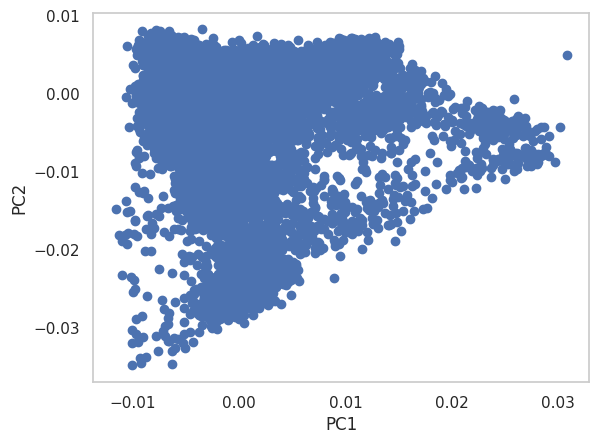

In [43]:
import pandas as pd
import matplotlib.pyplot as plt

# Read the .eigenvec file generated by PLINK
eigenvec_file = "PCA_results.eigenvec"
df = pd.read_csv(eigenvec_file, sep="\t")

# Create a scatter plot without grid lines
plt.scatter(df["PC1"], df["PC2"])
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.grid(False)  # Disable the grid
plt.savefig("EUR_PCA12_plot.png", dpi=300, bbox_inches='tight')
plt.show()  # Display the plot

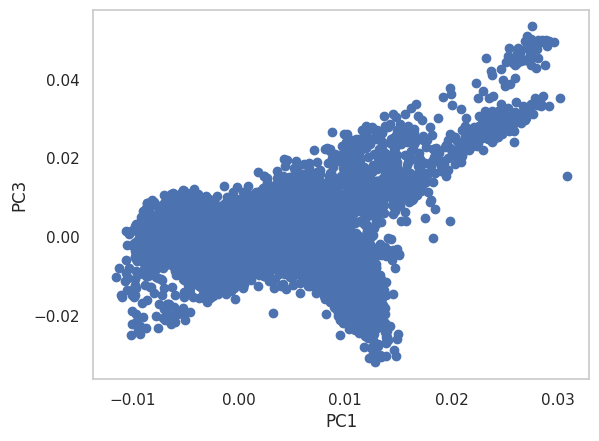

In [44]:
import pandas as pd
import matplotlib.pyplot as plt

# Read the .eigenvec file generated by PLINK
eigenvec_file = "PCA_results.eigenvec"
df = pd.read_csv(eigenvec_file, sep="\t")

# Create a scatter plot without grid lines
plt.scatter(df["PC1"], df["PC3"])
plt.xlabel("PC1")
plt.ylabel("PC3")
plt.grid(False)  # Disable the grid
plt.savefig("EUR_PCA13_plot.png", dpi=300, bbox_inches='tight')
plt.show()  # Display the plot

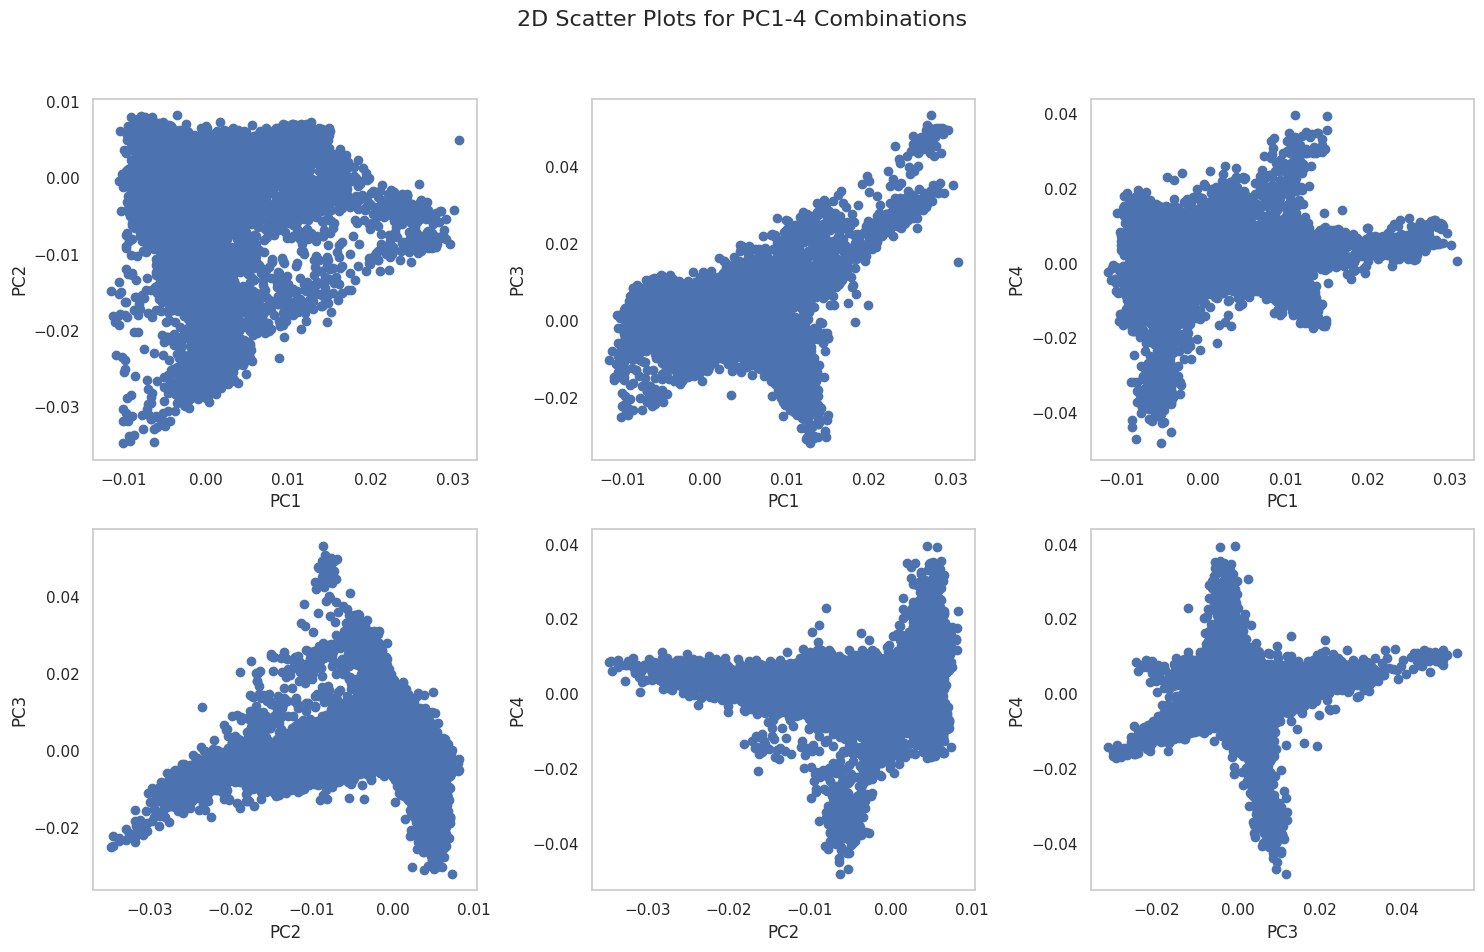

In [45]:
import matplotlib.pyplot as plt

# Define the combinations of PCs for the plots
combinations = [('PC1', 'PC2'), ('PC1', 'PC3'), ('PC1', 'PC4'), ('PC2', 'PC3'), ('PC2', 'PC4'), ('PC3', 'PC4')]

# Prepare the figure
fig, axs = plt.subplots(2, 3, figsize=(15, 10))  # Adjust the size as necessary
fig.suptitle('2D Scatter Plots for PC1-4 Combinations', fontsize=16)

for i, (pc_x, pc_y) in enumerate(combinations):
    ax = axs[i//3, i%3]  # Determine subplot position
    ax.scatter(df[pc_x], df[pc_y])
    ax.set_xlabel(pc_x)
    ax.set_ylabel(pc_y)
    ax.grid(False)  # Disable the grid

plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust the layout
plt.savefig("EUR_PCA_combinations_plot.png", dpi=300, bbox_inches='tight')  # Optionally save the figure
plt.show()  # Display the plot


In [22]:
# Read the PCA results with a more cautious approach
eigenvec_file = "PCA_results.eigenvec"
df = pd.read_csv(eigenvec_file, delim_whitespace=True, header=None, comment='#')

# Check the first few rows to understand the structure
print(df.head())

# Assuming the columns might not be labeled, and based on your initial description, 
# you may need to manually assign column names if they are not automatically detected
if df.columns[0] != 'FID':
    df.columns = ['FID', 'IID'] + [f'PC{i}' for i in range(1, 21)]
    
print("After setting column names:", df.head())


   0   1         2         3         4         5         6         7   \
0   1   1 -0.004166  0.000793 -0.000079 -0.003863 -0.000441  0.004090   
1   2   2 -0.002284  0.002675  0.002037  0.005556 -0.001138  0.001393   
2   3   3 -0.008330  0.004723 -0.000491  0.009824  0.006201 -0.007640   
3   4   4 -0.003731  0.000867  0.001331  0.003050  0.003486 -0.000243   
4   5   5 -0.004548  0.000404  0.002310 -0.004384 -0.001130  0.002286   

         8         9   ...        12        13        14        15        16  \
0  0.003283 -0.004418  ... -0.005068  0.002613  0.002198 -0.002584 -0.002826   
1 -0.000735 -0.004628  ... -0.008099 -0.003014 -0.001626 -0.007230  0.002685   
2  0.003425 -0.005039  ...  0.000595  0.000283 -0.002671  0.003032  0.003974   
3  0.001701 -0.000352  ... -0.004749  0.000497 -0.003677 -0.001587 -0.004654   
4  0.001065 -0.001415  ...  0.001078  0.006860  0.003081 -0.004123  0.006414   

         17        18        19        20        21  
0  0.002119 -0.003444 -0.0

### color coding based on batch

/tmp/ipykernel_168846/805262265.py:14: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('viridis', len(unique_batches))


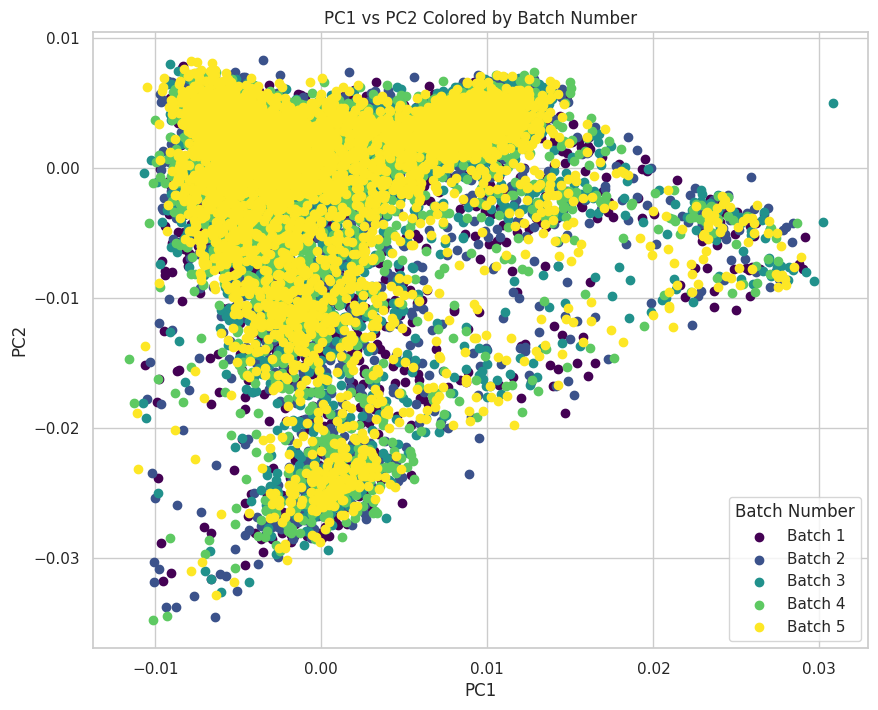

In [47]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Assuming df and Cov_Regenie are already loaded and prepared as shown before
df['IID'] = df['IID'].astype(str)
Cov_Regenie['IID'] = Cov_Regenie['IID'].astype(str)

# Merge the PCA results with the Cov_Regenie DataFrame to get the batch number
merged_df = pd.merge(df, Cov_Regenie[['IID', 'batch']], on='IID')

# Prepare for categorical coloring
unique_batches = sorted(merged_df['batch'].unique())
colors = plt.cm.get_cmap('viridis', len(unique_batches))

# Create a scatter plot, color-coded by batch number as categorical
plt.figure(figsize=(10, 8))
for i, batch in enumerate(unique_batches):
    subset = merged_df[merged_df['batch'] == batch]
    plt.scatter(subset["PC1"], subset["PC2"], color=colors(i), label=f'Batch {batch}')

plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend(title="Batch Number")
plt.title("PC1 vs PC2 Colored by Batch Number")
plt.savefig("eur_PCA12_plot_colored_by_batch_categorical.png", dpi=300, bbox_inches='tight')
plt.show()


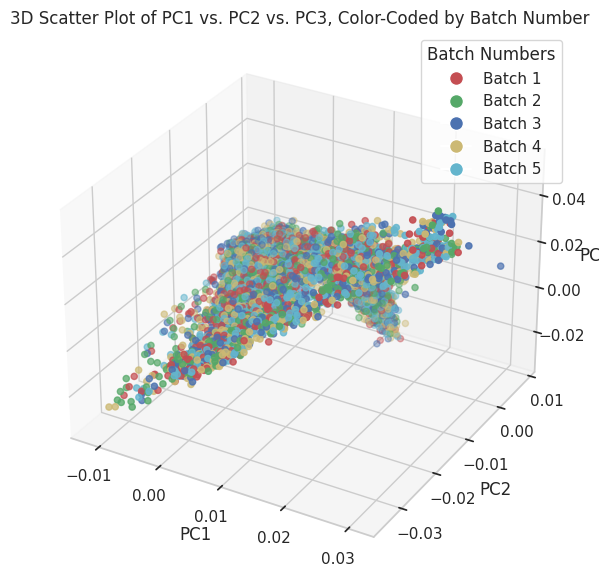

In [48]:
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Prepare the 3D plot
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Define a color map with distinct colors for each batch number
color_map = {1: 'r', 2: 'g', 3: 'b', 4: 'y', 5: 'c'}  # Red, Green, Blue, Yellow, Cyan for batches 1-5

# Assign colors based on the batch number using a list comprehension
colors = [color_map[batch] for batch in merged_df['batch']]

# Extracting PC2, PC3, and PC4 for the axes
x = merged_df['PC1']
y = merged_df['PC2']
z = merged_df['PC3']

# Create a scatter plot
scatter = ax.scatter(x, y, z, c=colors, label='Batch Number')

# Creating custom legends for the batch numbers
legend_labels = [plt.Line2D([0], [0], marker='o', color='w', label=f'Batch {i}',
                          markerfacecolor=color_map[i], markersize=10) for i in color_map]
ax.legend(handles=legend_labels, title="Batch Numbers")

# Setting the labels
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')

plt.title('3D Scatter Plot of PC1 vs. PC2 vs. PC3, Color-Coded by Batch Number')
plt.savefig("eur_PCA123_plot_colored_by_batch_categorical.png", dpi=300, bbox_inches='tight')
plt.show()


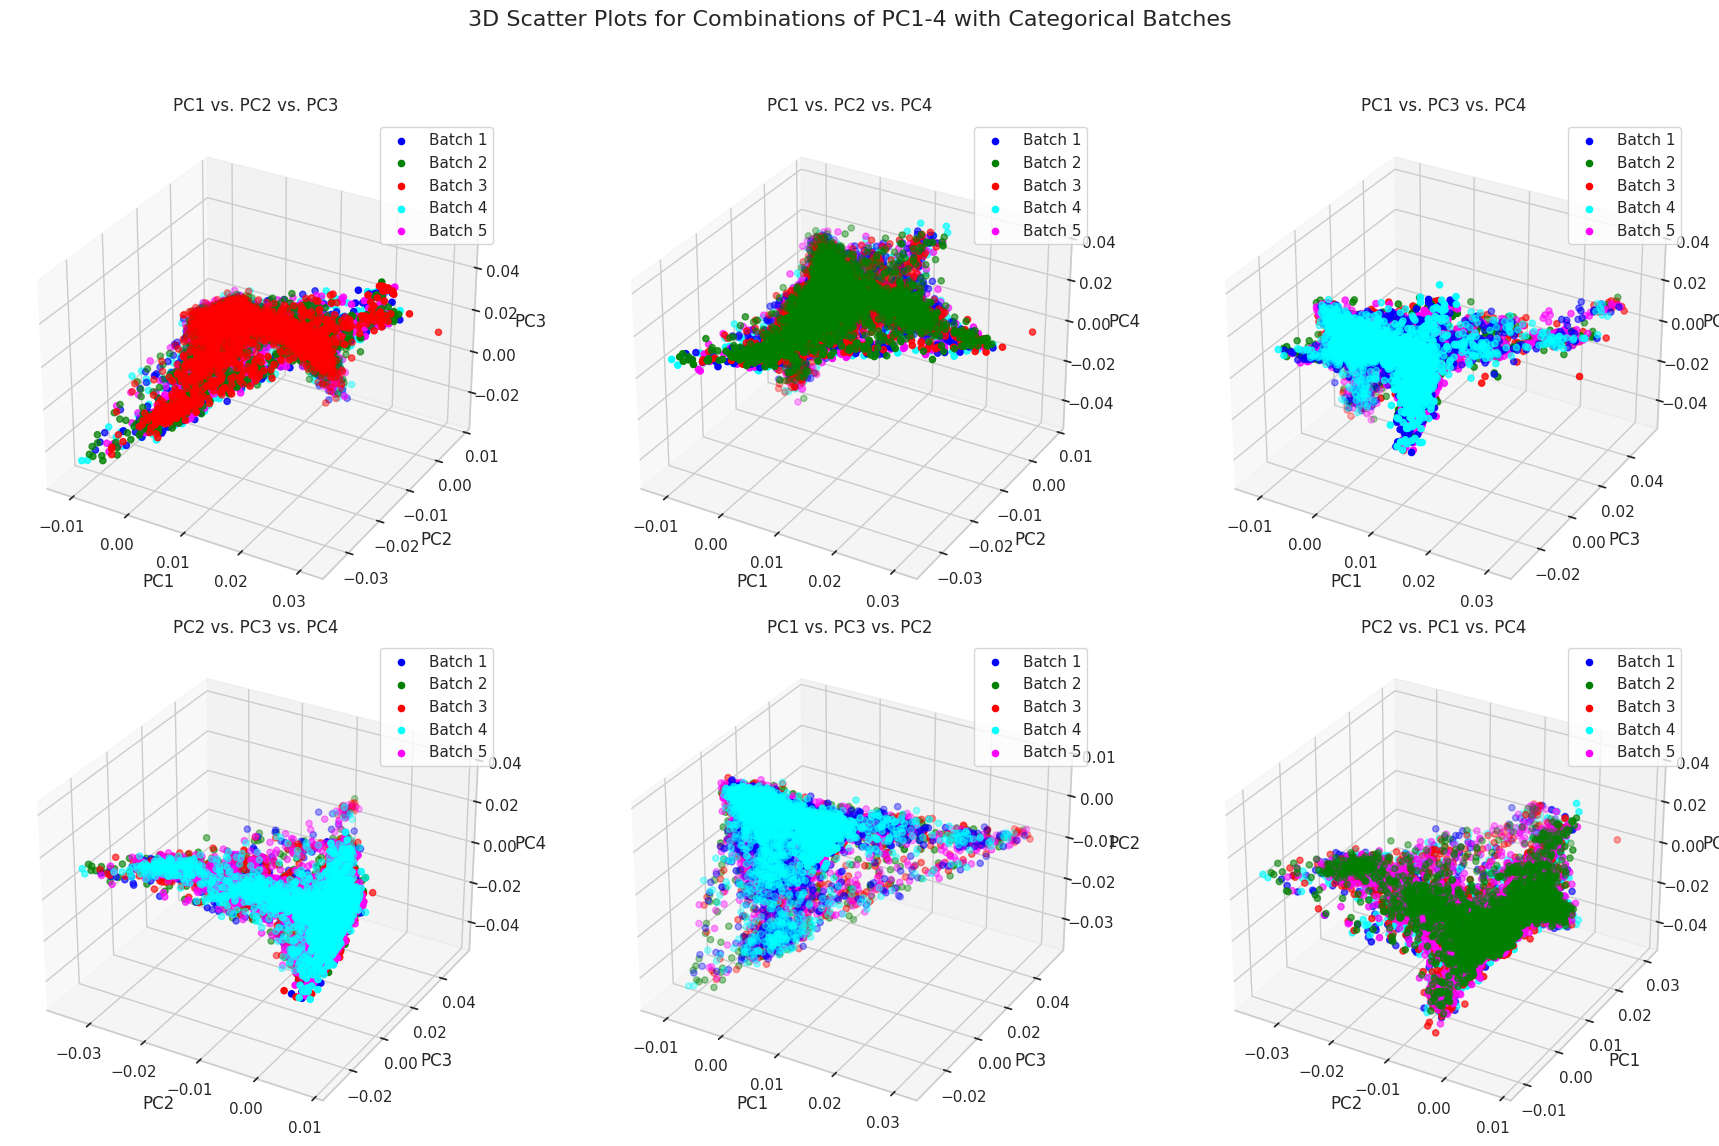

In [49]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Define specific colors for each batch
batch_colors = {1: 'blue', 2: 'green', 3: 'red', 4: 'cyan', 5: 'magenta'}

# Create combinations of PCs for plotting
pc_combinations = [('PC1', 'PC2', 'PC3'), ('PC1', 'PC2', 'PC4'), ('PC1', 'PC3', 'PC4'), 
                   ('PC2', 'PC3', 'PC4'), ('PC1', 'PC3', 'PC2'), ('PC2', 'PC1', 'PC4')]

# Prepare the figure and subplots
fig = plt.figure(figsize=(18, 12))
fig.suptitle('3D Scatter Plots for Combinations of PC1-4 with Categorical Batches', fontsize=16)

for i, (pc_x, pc_y, pc_z) in enumerate(pc_combinations, start=1):
    ax = fig.add_subplot(2, 3, i, projection='3d')

    # Plot each batch with its specific color
    for batch in sorted(merged_df['batch'].unique()):
        subset = merged_df[merged_df['batch'] == batch]
        ax.scatter(subset[pc_x], subset[pc_y], subset[pc_z], 
                   color=batch_colors[batch], label=f'Batch {batch}')

    # Setting labels
    ax.set_xlabel(pc_x)
    ax.set_ylabel(pc_y)
    ax.set_zlabel(pc_z)
    ax.set_title(f'{pc_x} vs. {pc_y} vs. {pc_z}')
    ax.legend()

# Adjust layout to prevent overlap
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig("eur_PCA1234_plot_colored_by_batch_combination.png", dpi=300, bbox_inches='tight')
plt.show()


### color coding based on sex

In [50]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Assuming df contains your PCA results and has been properly merged with Cov_Regenie for other purposes
# Merge df with Cov_Regenie on 'IID' to include the 'sex' column for plotting
# Make sure 'IID' columns in both DataFrames are of the same data type
df['IID'] = df['IID'].astype(str)
Cov_Regenie['IID'] = Cov_Regenie['IID'].astype(str)

# Merge on 'IID' to include the 'sex' column
plotting_df = pd.merge(df, Cov_Regenie[['IID', 'sex']], on='IID')

# Define specific colors for each sex value
sex_colors = {1: 'blue', 2: 'orange'}

# Create combinations of PCs for plotting
pc_combinations = [('PC1', 'PC2', 'PC3'), ('PC1', 'PC2', 'PC4'), ('PC1', 'PC3', 'PC4'), 
                   ('PC2', 'PC3', 'PC4'), ('PC1', 'PC3', 'PC2'), ('PC2', 'PC1', 'PC4')]

# Prepare the figure and subplots
fig = plt.figure(figsize=(18, 12))
fig.suptitle('3D Scatter Plots for Combinations of PC1-4 with Categorical Sex', fontsize=16)

for i, (pc_x, pc_y, pc_z) in enumerate(pc_combinations, start=1):
    ax = fig.add_subplot(2, 3, i, projection='3d')

    # Plot each sex with its specific color
    for sex in sorted(plotting_df['sex'].unique()):
        subset = plotting_df[plotting_df['sex'] == sex]
        ax.scatter(subset[pc_x], subset[pc_y], subset[pc_z], 
                   color=sex_colors[sex], label=f'Sex {sex}')

    # Setting labels
    ax.set_xlabel(pc_x)
    ax.set_ylabel(pc_y)
    ax.set_zlabel(pc_z)
    ax.set_title(f'{pc_x} vs. {pc_y} vs. {pc_z}')
    ax.legend()

# Adjust layout to prevent overlap
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig("eur_PCA1234_plot_colored_by_sex.png", dpi=300, bbox_inches='tight')
plt.show()

In [51]:
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Assuming df is your PCA results DataFrame and Cov_Regenie contains the sex information
# Make sure 'IID' columns in both DataFrames are of the same data type for a successful merge
df['IID'] = df['IID'].astype(str)
Cov_Regenie['IID'] = Cov_Regenie['IID'].astype(str)

# Merge on 'IID' to include the 'sex' column for plotting
plotting_df = pd.merge(df, Cov_Regenie[['IID', 'sex']], on='IID')

# Define specific colors for each sex value
sex_colors = {1: 'blue', 2: 'orange'}

# Prepare the 3D plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot each sex with its specific color
for sex in sorted(plotting_df['sex'].unique()):
    subset = plotting_df[plotting_df['sex'] == sex]
    ax.scatter(subset['PC1'], subset['PC2'], subset['PC3'], 
               color=sex_colors[sex], label=f'Sex {sex}')

# Setting the labels
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
ax.set_title('3D Scatter Plot of PC1 vs. PC2 vs. PC3 Color-coded by Sex')
ax.legend()
plt.savefig("eur_PCA123_plot_colored_by_sex.png", dpi=300, bbox_inches='tight')
plt.show()


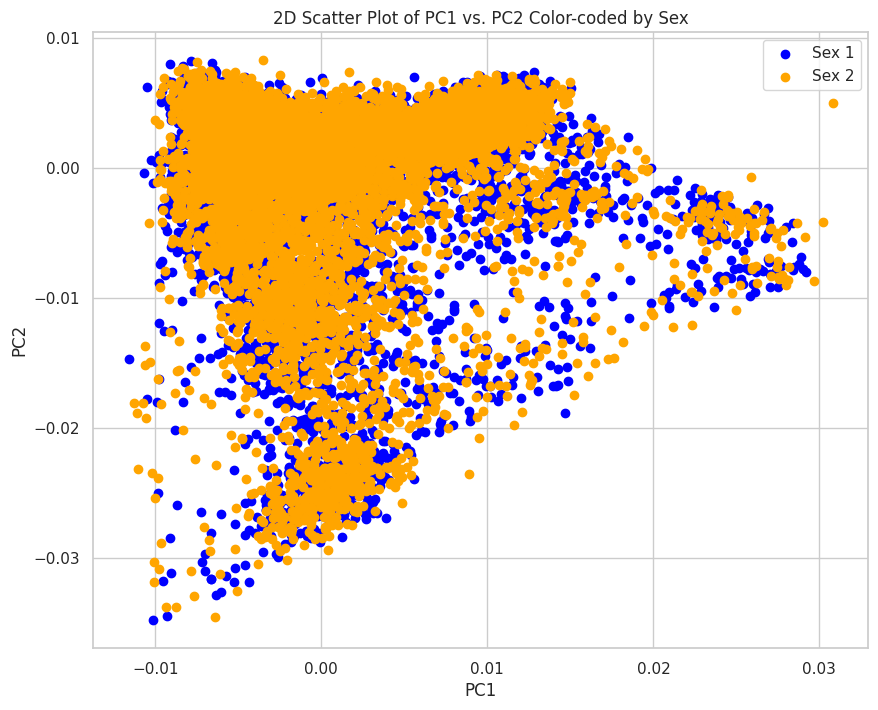

In [52]:
import matplotlib.pyplot as plt

# Assuming plotting_df is already created by merging df with Cov_Regenie including the 'sex' column
# Define specific colors for each sex value
sex_colors = {1: 'blue', 2: 'orange'}

# Prepare the 2D plot
plt.figure(figsize=(10, 8))

# Plot each sex with its specific color
for sex in sorted(plotting_df['sex'].unique()):
    subset = plotting_df[plotting_df['sex'] == sex]
    plt.scatter(subset['PC1'], subset['PC2'], color=sex_colors[sex], label=f'Sex {sex}')

# Setting the labels and title
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('2D Scatter Plot of PC1 vs. PC2 Color-coded by Sex')
plt.legend()
plt.savefig("eur_PCA12_plot_colored_by_sex.png", dpi=300, bbox_inches='tight')
plt.show()


In [53]:
import matplotlib.pyplot as plt

# Define combinations of PCs for the 2D plots
pc_combinations = [('PC1', 'PC2'), ('PC1', 'PC3'), ('PC1', 'PC4'), ('PC2', 'PC3'), ('PC2', 'PC4'), ('PC3', 'PC4')]

# Define specific colors for each sex value
sex_colors = {1: 'blue', 2: 'orange'}

# Prepare the master plot
fig, axes = plt.subplots(2, 3, figsize=(18, 12))  # Adjust the layout as needed
fig.suptitle('2D Scatter Plots for Combinations of PC1-4 with Categorical Sex', fontsize=16)

for i, (pc_x, pc_y) in enumerate(pc_combinations):
    ax = axes[i // 3, i % 3]  # Determine the subplot position based on the index
    
    # Plot each sex with its specific color in the subplot
    for sex in sorted(plotting_df['sex'].unique()):
        subset = plotting_df[plotting_df['sex'] == sex]
        ax.scatter(subset[pc_x], subset[pc_y], color=sex_colors[sex], label=f'Sex {sex}' if i == 0 else "")
    
    ax.set_xlabel(pc_x)
    ax.set_ylabel(pc_y)
    ax.set_title(f'{pc_x} vs. {pc_y}')

# Add a legend to the first subplot for clarity
axes[0, 0].legend()

plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust layout to prevent overlap
plt.savefig("eur_PCA1234_2dplot_colored_by_sex_combo.png", dpi=300, bbox_inches='tight')
plt.show()


### color coding based on case/control for some large-sample traits

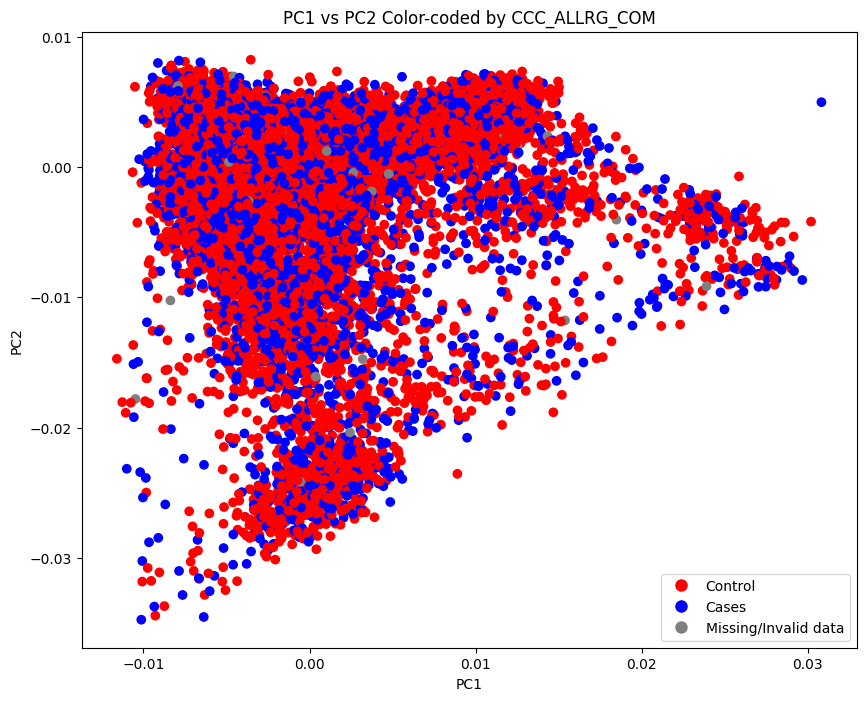

In [6]:
# Allergies
import pandas as pd
import matplotlib.pyplot as plt

# Load PCA results
eigenvec_file = "PCA_results.eigenvec"
df_pca = pd.read_csv(eigenvec_file, sep="\t", dtype={"IID": str})

# Load phenotype data
phenotypes_file = "PHENOTYPES_FILE_Mar9.csv"
df_pheno = pd.read_csv(phenotypes_file, sep=' ', dtype={"IID": str})

# Merge the PCA results with the phenotype data on 'IID'
merged_df = pd.merge(df_pca, df_pheno[['IID', 'CCC_ALLRG_COM']], on='IID')

# Since 'CCC_ALLRG_COM' may have NaNs or non-numeric values, ensure it's numeric and handle NaNs
merged_df['CCC_ALLRG_COM'] = pd.to_numeric(merged_df['CCC_ALLRG_COM'], errors='coerce').fillna(-1)

# Define colors for the categories in 'CCC_ALLRG_COM', including a color for missing data if necessary
color_map = {0: 'red', 1: 'blue', -1: 'gray'}  # -1 for NaN or any non-numeric values

# Create a scatter plot of PC1 vs. PC3, color-coded by 'CCC_ALLRG_COM' value
plt.figure(figsize=(10, 8))
colors = merged_df['CCC_ALLRG_COM'].map(color_map)
plt.scatter(merged_df['PC1'], merged_df['PC2'], c=colors)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.grid(False)  # Disable the grid
plt.title('PC1 vs PC2 Color-coded by CCC_ALLRG_COM')

# Create a custom legend
from matplotlib.lines import Line2D
legend_elements = [
    Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=10, label='Control'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', markersize=10, label='Cases'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='gray', markersize=10, label='Missing/Invalid data')
]
plt.legend(handles=legend_elements)
plt.savefig("eur_PCA12_plot_colored_CCC_ALLRG_COM.png", dpi=300, bbox_inches='tight')
plt.show()


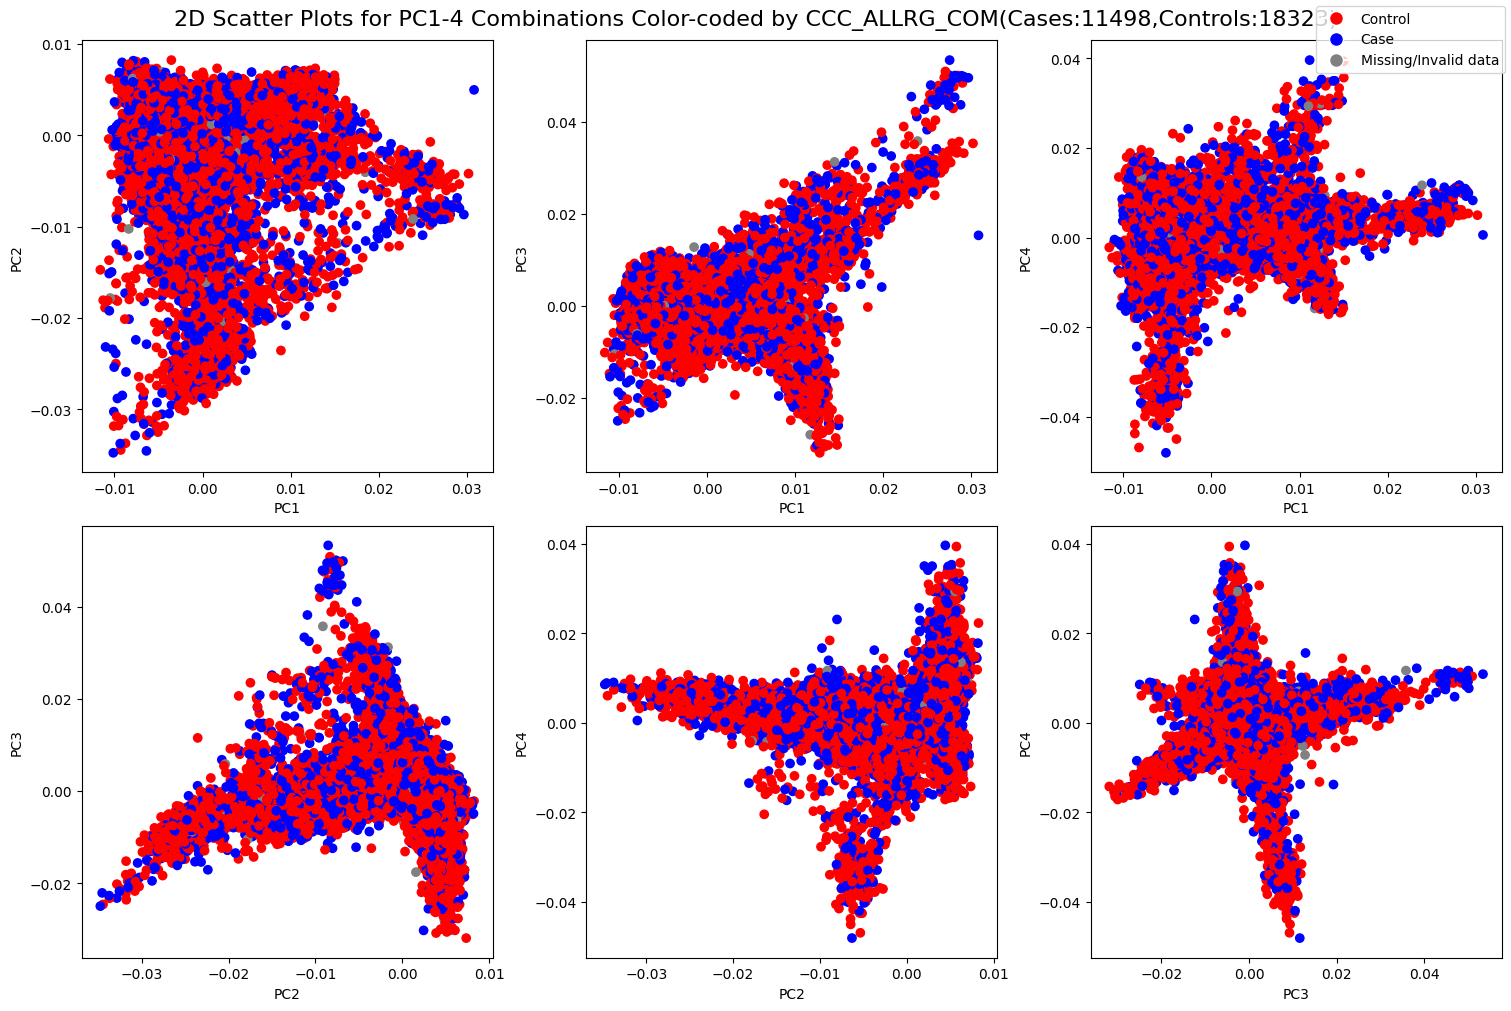

In [9]:
# Allergies
import pandas as pd
import matplotlib.pyplot as plt

# Load PCA results
eigenvec_file = "PCA_results.eigenvec"
df_pca = pd.read_csv(eigenvec_file, sep="\t", dtype={"IID": str})

# Load phenotype data
phenotypes_file = "PHENOTYPES_FILE_Mar9.csv"
df_pheno = pd.read_csv(phenotypes_file, sep=' ', dtype={"IID": str})

# Merge the PCA results with the phenotype data on 'IID'
merged_df = pd.merge(df_pca, df_pheno[['IID', 'CCC_ALLRG_COM']], on='IID')

# Handle non-numeric values in 'CCC_ALLRG_COM', converting to numeric and marking NaNs with -1
merged_df['CCC_ALLRG_COM'] = pd.to_numeric(merged_df['CCC_ALLRG_COM'], errors='coerce').fillna(-1)

# Define the color map for 'CCC_ALLRG_COM' values
color_map = {0: 'red', 1: 'blue', -1: 'gray'}

# Define the combinations of PCs for plotting
pc_combinations = [('PC1', 'PC2'), ('PC1', 'PC3'), ('PC1', 'PC4'), 
                   ('PC2', 'PC3'), ('PC2', 'PC4'), ('PC3', 'PC4')]

# Prepare the master plot
fig, axs = plt.subplots(2, 3, figsize=(15, 10), constrained_layout=True)
fig.suptitle('2D Scatter Plots for PC1-4 Combinations Color-coded by CCC_ALLRG_COM(Cases:11498,Controls:18323)', fontsize=16)

for ax, (pc_x, pc_y) in zip(axs.flat, pc_combinations):
    colors = merged_df['CCC_ALLRG_COM'].map(color_map)
    ax.scatter(merged_df[pc_x], merged_df[pc_y], c=colors)
    ax.set_xlabel(pc_x)
    ax.set_ylabel(pc_y)
    ax.grid(False)  # Disable the grid

# Create a custom legend for the whole figure
from matplotlib.lines import Line2D
legend_elements = [
    Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=10, label='Control'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', markersize=10, label='Case'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='gray', markersize=10, label='Missing/Invalid data')
]
fig.legend(handles=legend_elements, loc='upper right')
plt.savefig("eur_PCA1234_plot_colored_CCC_ALLRG_COM.png", dpi=300, bbox_inches='tight')
plt.show()


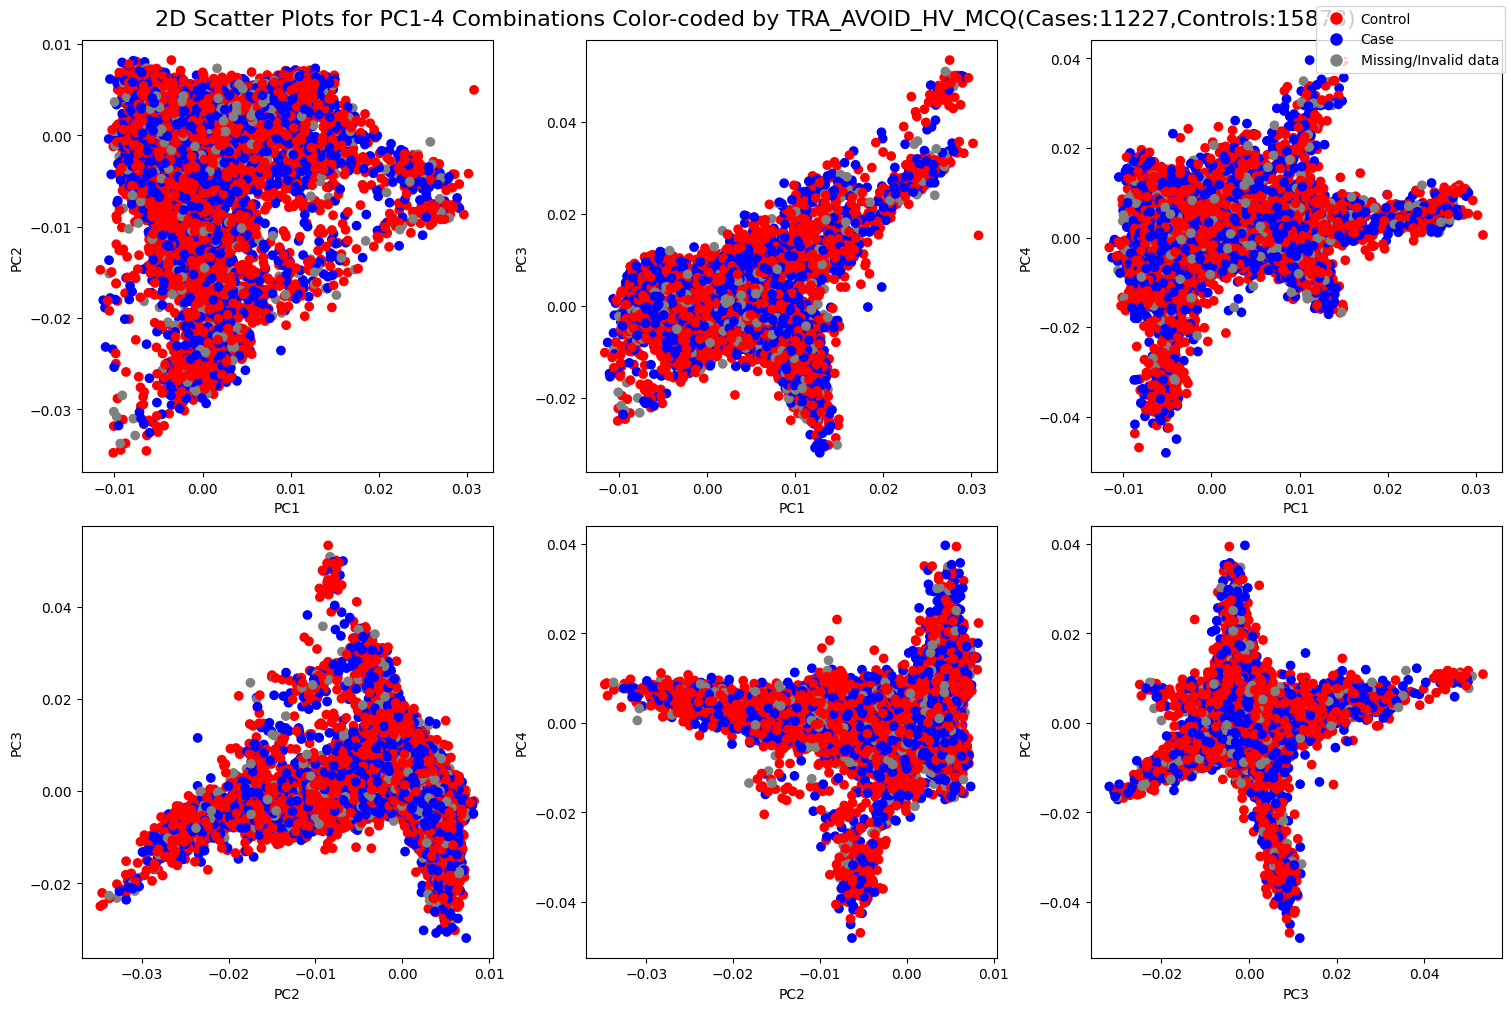

In [11]:
# Participant avoids: Heavy traffic
import pandas as pd
import matplotlib.pyplot as plt

# Load PCA results
eigenvec_file = "PCA_results.eigenvec"
df_pca = pd.read_csv(eigenvec_file, sep="\t", dtype={"IID": str})

# Load phenotype data
phenotypes_file = "PHENOTYPES_FILE_Mar9.csv"
df_pheno = pd.read_csv(phenotypes_file, sep=' ', dtype={"IID": str})

# Merge the PCA results with the phenotype data on 'IID'
merged_df = pd.merge(df_pca, df_pheno[['IID', 'TRA_AVOID_HV_MCQ']], on='IID')

# Handle non-numeric values in 'CCC_ALLRG_COM', converting to numeric and marking NaNs with -1
merged_df['TRA_AVOID_HV_MCQ'] = pd.to_numeric(merged_df['TRA_AVOID_HV_MCQ'], errors='coerce').fillna(-1)

# Define the color map for 'CCC_ALLRG_COM' values
color_map = {0: 'red', 1: 'blue', -1: 'gray'}

# Define the combinations of PCs for plotting
pc_combinations = [('PC1', 'PC2'), ('PC1', 'PC3'), ('PC1', 'PC4'), 
                   ('PC2', 'PC3'), ('PC2', 'PC4'), ('PC3', 'PC4')]

# Prepare the master plot
fig, axs = plt.subplots(2, 3, figsize=(15, 10), constrained_layout=True)
fig.suptitle('2D Scatter Plots for PC1-4 Combinations Color-coded by TRA_AVOID_HV_MCQ(Cases:11227,Controls:15878)', fontsize=16)

for ax, (pc_x, pc_y) in zip(axs.flat, pc_combinations):
    colors = merged_df['TRA_AVOID_HV_MCQ'].map(color_map)
    ax.scatter(merged_df[pc_x], merged_df[pc_y], c=colors)
    ax.set_xlabel(pc_x)
    ax.set_ylabel(pc_y)
    ax.grid(False)  # Disable the grid

# Create a custom legend for the whole figure
from matplotlib.lines import Line2D
legend_elements = [
    Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=10, label='Control'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', markersize=10, label='Case'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='gray', markersize=10, label='Missing/Invalid data')
]
fig.legend(handles=legend_elements, loc='upper right')
plt.savefig("eur_PCA1234_plot_colored_TRA_AVOID_HV_MCQ.png", dpi=300, bbox_inches='tight')
plt.show()


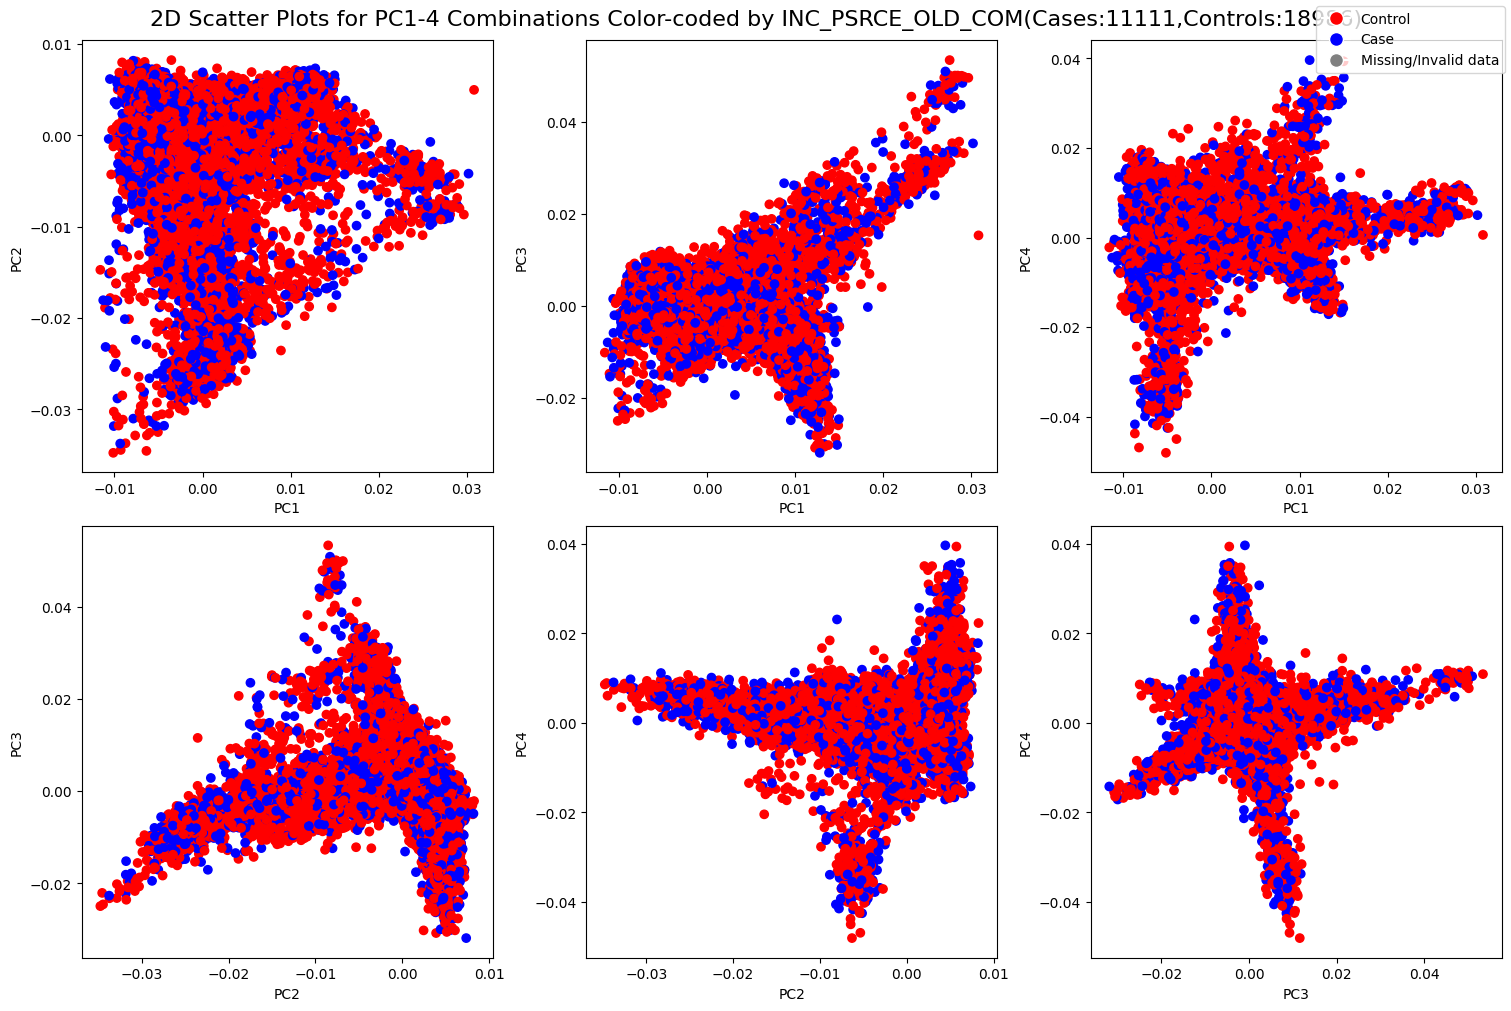

In [12]:
# Personal old age security
import pandas as pd
import matplotlib.pyplot as plt

# Load PCA results
eigenvec_file = "PCA_results.eigenvec"
df_pca = pd.read_csv(eigenvec_file, sep="\t", dtype={"IID": str})

# Load phenotype data
phenotypes_file = "PHENOTYPES_FILE_Mar9.csv"
df_pheno = pd.read_csv(phenotypes_file, sep=' ', dtype={"IID": str})

# Merge the PCA results with the phenotype data on 'IID'
merged_df = pd.merge(df_pca, df_pheno[['IID', 'INC_PSRCE_OLD_COM']], on='IID')

# Handle non-numeric values in 'CCC_ALLRG_COM', converting to numeric and marking NaNs with -1
merged_df['INC_PSRCE_OLD_COM'] = pd.to_numeric(merged_df['INC_PSRCE_OLD_COM'], errors='coerce').fillna(-1)

# Define the color map for 'CCC_ALLRG_COM' values
color_map = {0: 'red', 1: 'blue', -1: 'gray'}

# Define the combinations of PCs for plotting
pc_combinations = [('PC1', 'PC2'), ('PC1', 'PC3'), ('PC1', 'PC4'), 
                   ('PC2', 'PC3'), ('PC2', 'PC4'), ('PC3', 'PC4')]

# Prepare the master plot
fig, axs = plt.subplots(2, 3, figsize=(15, 10), constrained_layout=True)
fig.suptitle('2D Scatter Plots for PC1-4 Combinations Color-coded by INC_PSRCE_OLD_COM(Cases:11111,Controls:18986)', fontsize=16)

for ax, (pc_x, pc_y) in zip(axs.flat, pc_combinations):
    colors = merged_df['INC_PSRCE_OLD_COM'].map(color_map)
    ax.scatter(merged_df[pc_x], merged_df[pc_y], c=colors)
    ax.set_xlabel(pc_x)
    ax.set_ylabel(pc_y)
    ax.grid(False)  # Disable the grid

# Create a custom legend for the whole figure
from matplotlib.lines import Line2D
legend_elements = [
    Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=10, label='Control'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', markersize=10, label='Case'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='gray', markersize=10, label='Missing/Invalid data')
]
fig.legend(handles=legend_elements, loc='upper right')
plt.savefig("eur_PCA1234_plot_colored_INC_PSRCE_OLD_COM.png", dpi=300, bbox_inches='tight')
plt.show()


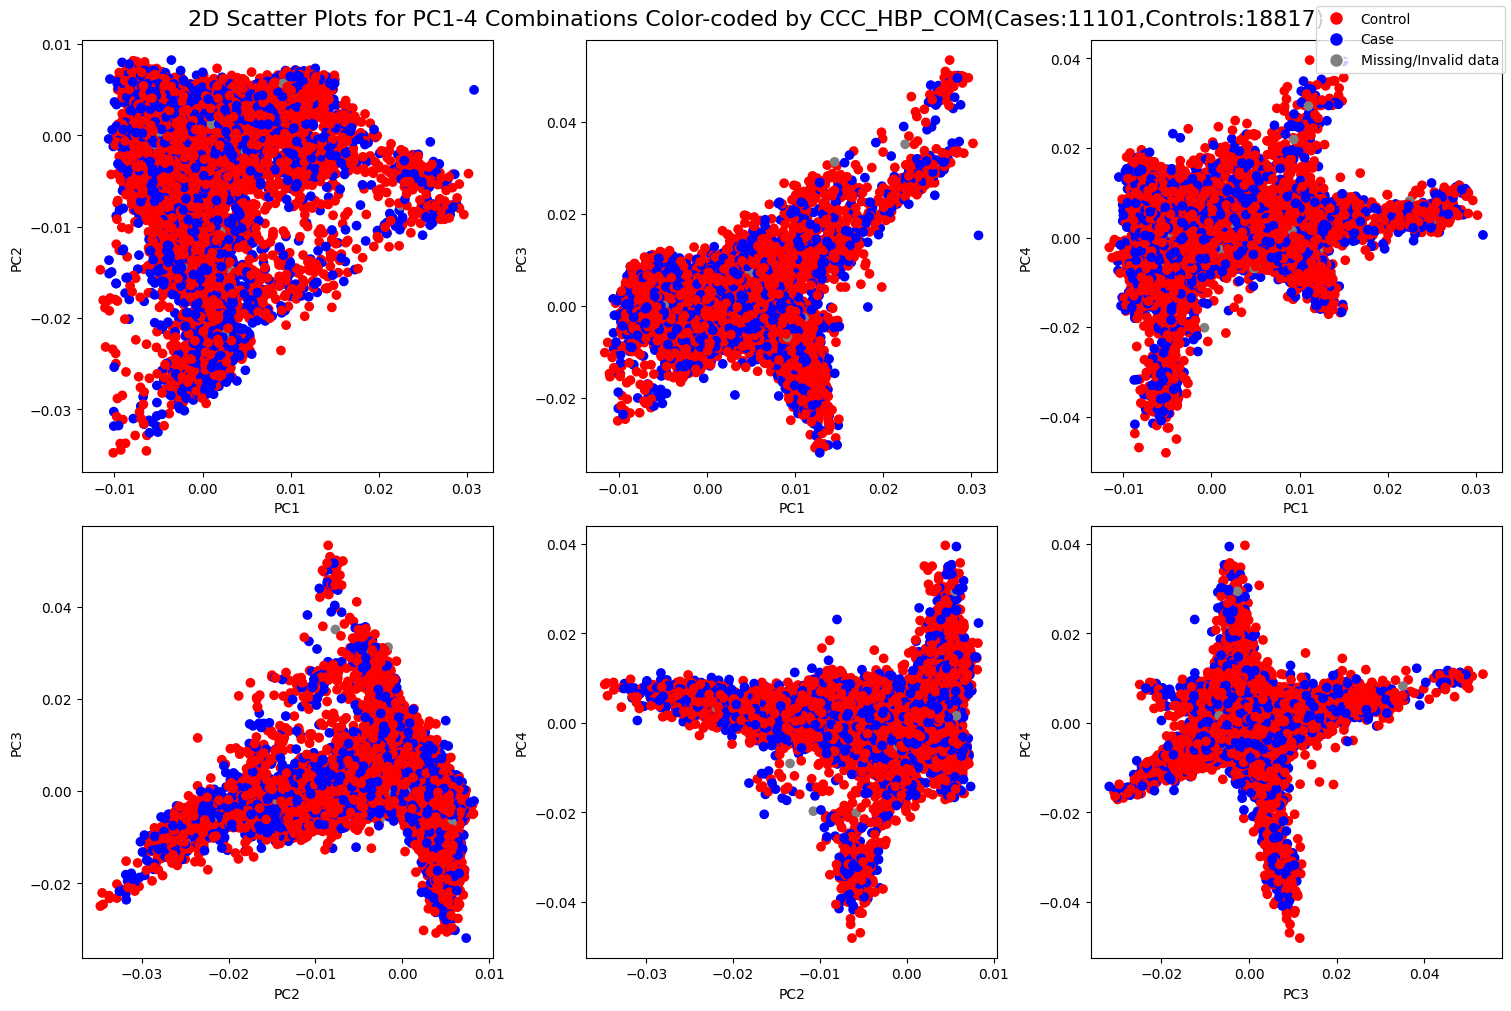

In [13]:
# High blood pressure or hypertension
import pandas as pd
import matplotlib.pyplot as plt

# Load PCA results
eigenvec_file = "PCA_results.eigenvec"
df_pca = pd.read_csv(eigenvec_file, sep="\t", dtype={"IID": str})

# Load phenotype data
phenotypes_file = "PHENOTYPES_FILE_Mar9.csv"
df_pheno = pd.read_csv(phenotypes_file, sep=' ', dtype={"IID": str})

# Merge the PCA results with the phenotype data on 'IID'
merged_df = pd.merge(df_pca, df_pheno[['IID', 'CCC_HBP_COM']], on='IID')

# Handle non-numeric values in 'CCC_ALLRG_COM', converting to numeric and marking NaNs with -1
merged_df['CCC_HBP_COM'] = pd.to_numeric(merged_df['CCC_HBP_COM'], errors='coerce').fillna(-1)

# Define the color map for 'CCC_ALLRG_COM' values
color_map = {0: 'red', 1: 'blue', -1: 'gray'}

# Define the combinations of PCs for plotting
pc_combinations = [('PC1', 'PC2'), ('PC1', 'PC3'), ('PC1', 'PC4'), 
                   ('PC2', 'PC3'), ('PC2', 'PC4'), ('PC3', 'PC4')]

# Prepare the master plot
fig, axs = plt.subplots(2, 3, figsize=(15, 10), constrained_layout=True)
fig.suptitle('2D Scatter Plots for PC1-4 Combinations Color-coded by CCC_HBP_COM(Cases:11101,Controls:18817)', fontsize=16)

for ax, (pc_x, pc_y) in zip(axs.flat, pc_combinations):
    colors = merged_df['CCC_HBP_COM'].map(color_map)
    ax.scatter(merged_df[pc_x], merged_df[pc_y], c=colors)
    ax.set_xlabel(pc_x)
    ax.set_ylabel(pc_y)
    ax.grid(False)  # Disable the grid

# Create a custom legend for the whole figure
from matplotlib.lines import Line2D
legend_elements = [
    Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=10, label='Control'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', markersize=10, label='Case'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='gray', markersize=10, label='Missing/Invalid data')
]
fig.legend(handles=legend_elements, loc='upper right')
plt.savefig("eur_PCA1234_plot_colored_CCC_HBP_COM.png", dpi=300, bbox_inches='tight')
plt.show()


## Scree plot

/tmp/ipykernel_3763381/3335306932.py:8: FutureWarning: The squeeze argument has been deprecated and will be removed in a future version. Append .squeeze("columns") to the call to squeeze.


  eigenvalues = pd.read_csv(file_path, header=None, squeeze=True)


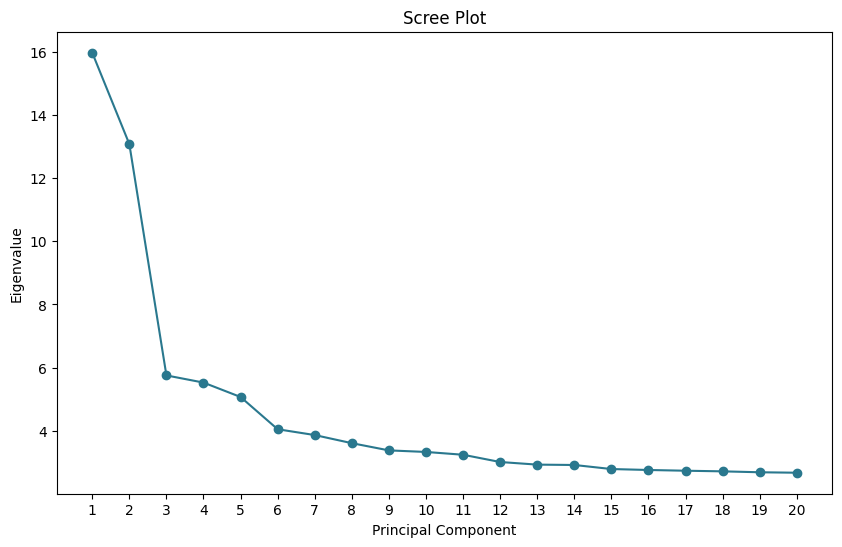

In [10]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming a correct file path is provided and accessible
file_path = 'PCA_results.eigenval'

# Read the eigenvalues from the file, each eigenvalue is on a new line
eigenvalues = pd.read_csv(file_path, header=None, squeeze=True)

# Generate the scree plot with a line plot
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(eigenvalues)+1), eigenvalues, marker='o', linestyle='-', color=plt.cm.viridis(0.4))
plt.xlabel('Principal Component')
plt.ylabel('Eigenvalue')
plt.xticks(range(1, len(eigenvalues)+1))
plt.title('Scree Plot')
plt.savefig("PCA_scree_plot.png", dpi=300, bbox_inches='tight')
plt.show()

/tmp/ipykernel_168846/1480653359.py:8: FutureWarning: The squeeze argument has been deprecated and will be removed in a future version. Append .squeeze("columns") to the call to squeeze.


  eigenvalues = pd.read_csv(file_path, header=None, squeeze=True)


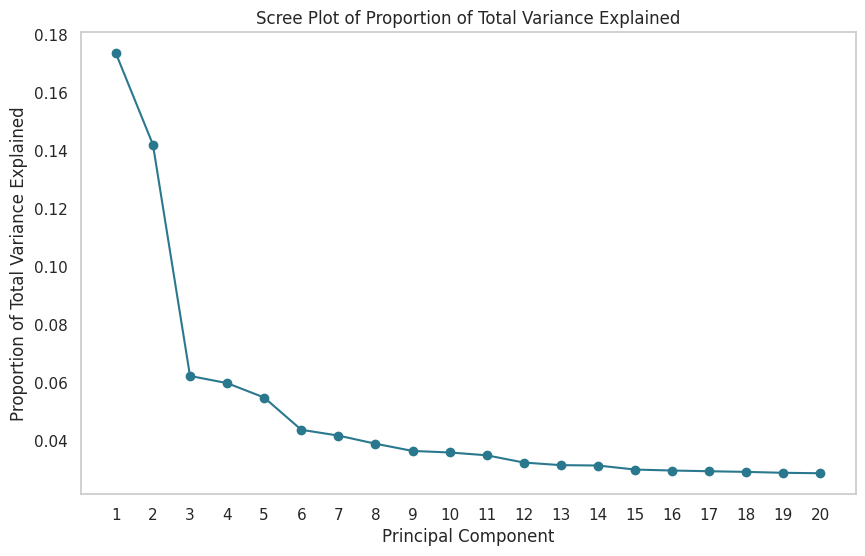

In [18]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming a correct file path is provided and accessible
file_path = 'PCA_results.eigenval'

# Read the eigenvalues from the file, each eigenvalue is on a new line
eigenvalues = pd.read_csv(file_path, header=None, squeeze=True)

# Calculate the proportion of variance explained for each eigenvalue
total_variance = eigenvalues.sum()
proportion_variance_explained = eigenvalues / total_variance

# Generate the scree plot for the proportion of variance explained
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(proportion_variance_explained)+1), proportion_variance_explained, marker='o', linestyle='-', color=plt.cm.viridis(0.4))
plt.xlabel('Principal Component')
plt.ylabel('Proportion of Total Variance Explained')
plt.xticks(range(1, len(proportion_variance_explained)+1))
plt.title('Scree Plot of Proportion of Total Variance Explained')
plt.grid(False)  # Remove the grid lines in the background
plt.savefig("PCA_proportion_variance_explained.png", dpi=300, bbox_inches='tight')
plt.show()


## Boxplots

In [34]:
# Cov_Regenie

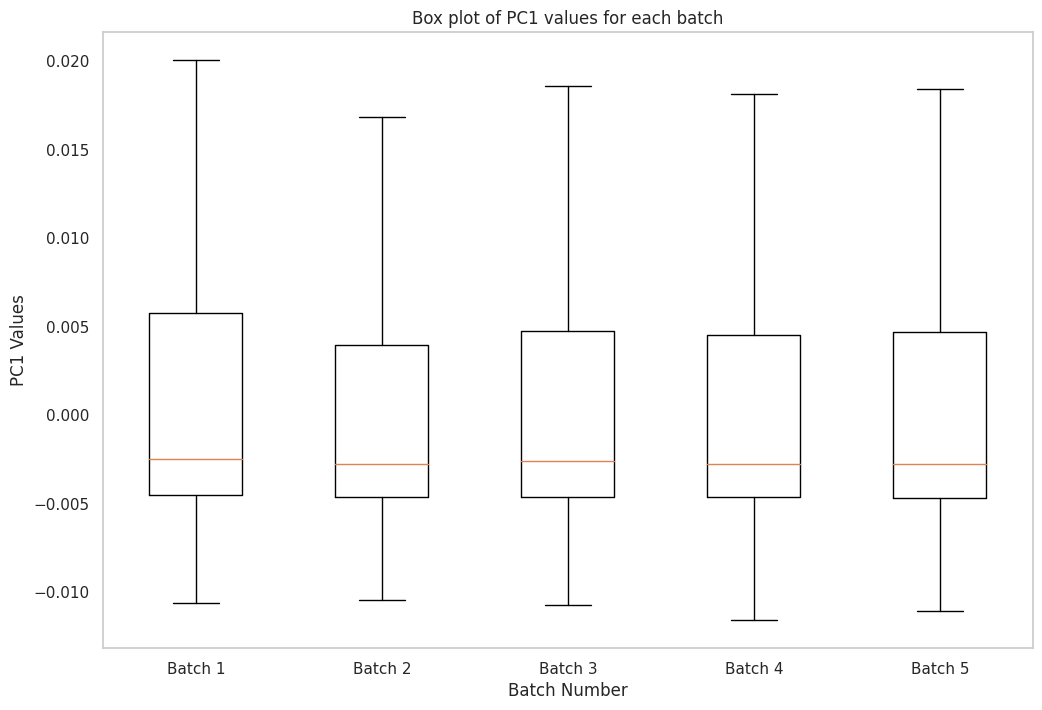

In [14]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming Cov_Regenie is your DataFrame
# Convert PC1 to numeric, errors='coerce' will set invalid parsing to NaN
Cov_Regenie['PC1'] = pd.to_numeric(Cov_Regenie['PC1'], errors='coerce')

# Initialize a list to hold the PC1 values for each batch
pc1_values_for_batches = []

# Loop through each batch number (1 to 5)
for batch_number in range(1, 6):
    # Filter the DataFrame for the current batch
    batch_data = Cov_Regenie[Cov_Regenie['batch'] == batch_number]
    
    # Append the filtered PC1 values to the list (drop NaN values)
    pc1_values_for_batches.append(batch_data['PC1'].dropna())

# Generate the box plots for each batch
plt.figure(figsize=(12, 8))  # Adjust the figure size as needed
plt.boxplot(pc1_values_for_batches, showfliers=False)  # Plot without outliers
plt.title('Box plot of PC1 values for each batch')
plt.xlabel('Batch Number')
plt.ylabel('PC1 Values')
plt.xticks([1, 2, 3, 4, 5], ['Batch 1', 'Batch 2', 'Batch 3', 'Batch 4', 'Batch 5'])  # Set the x-ticks to match batch numbers
plt.grid(False)  # Disable the background grid
plt.savefig("PC1_boxplot_plot.png", dpi=300, bbox_inches='tight')
plt.show()


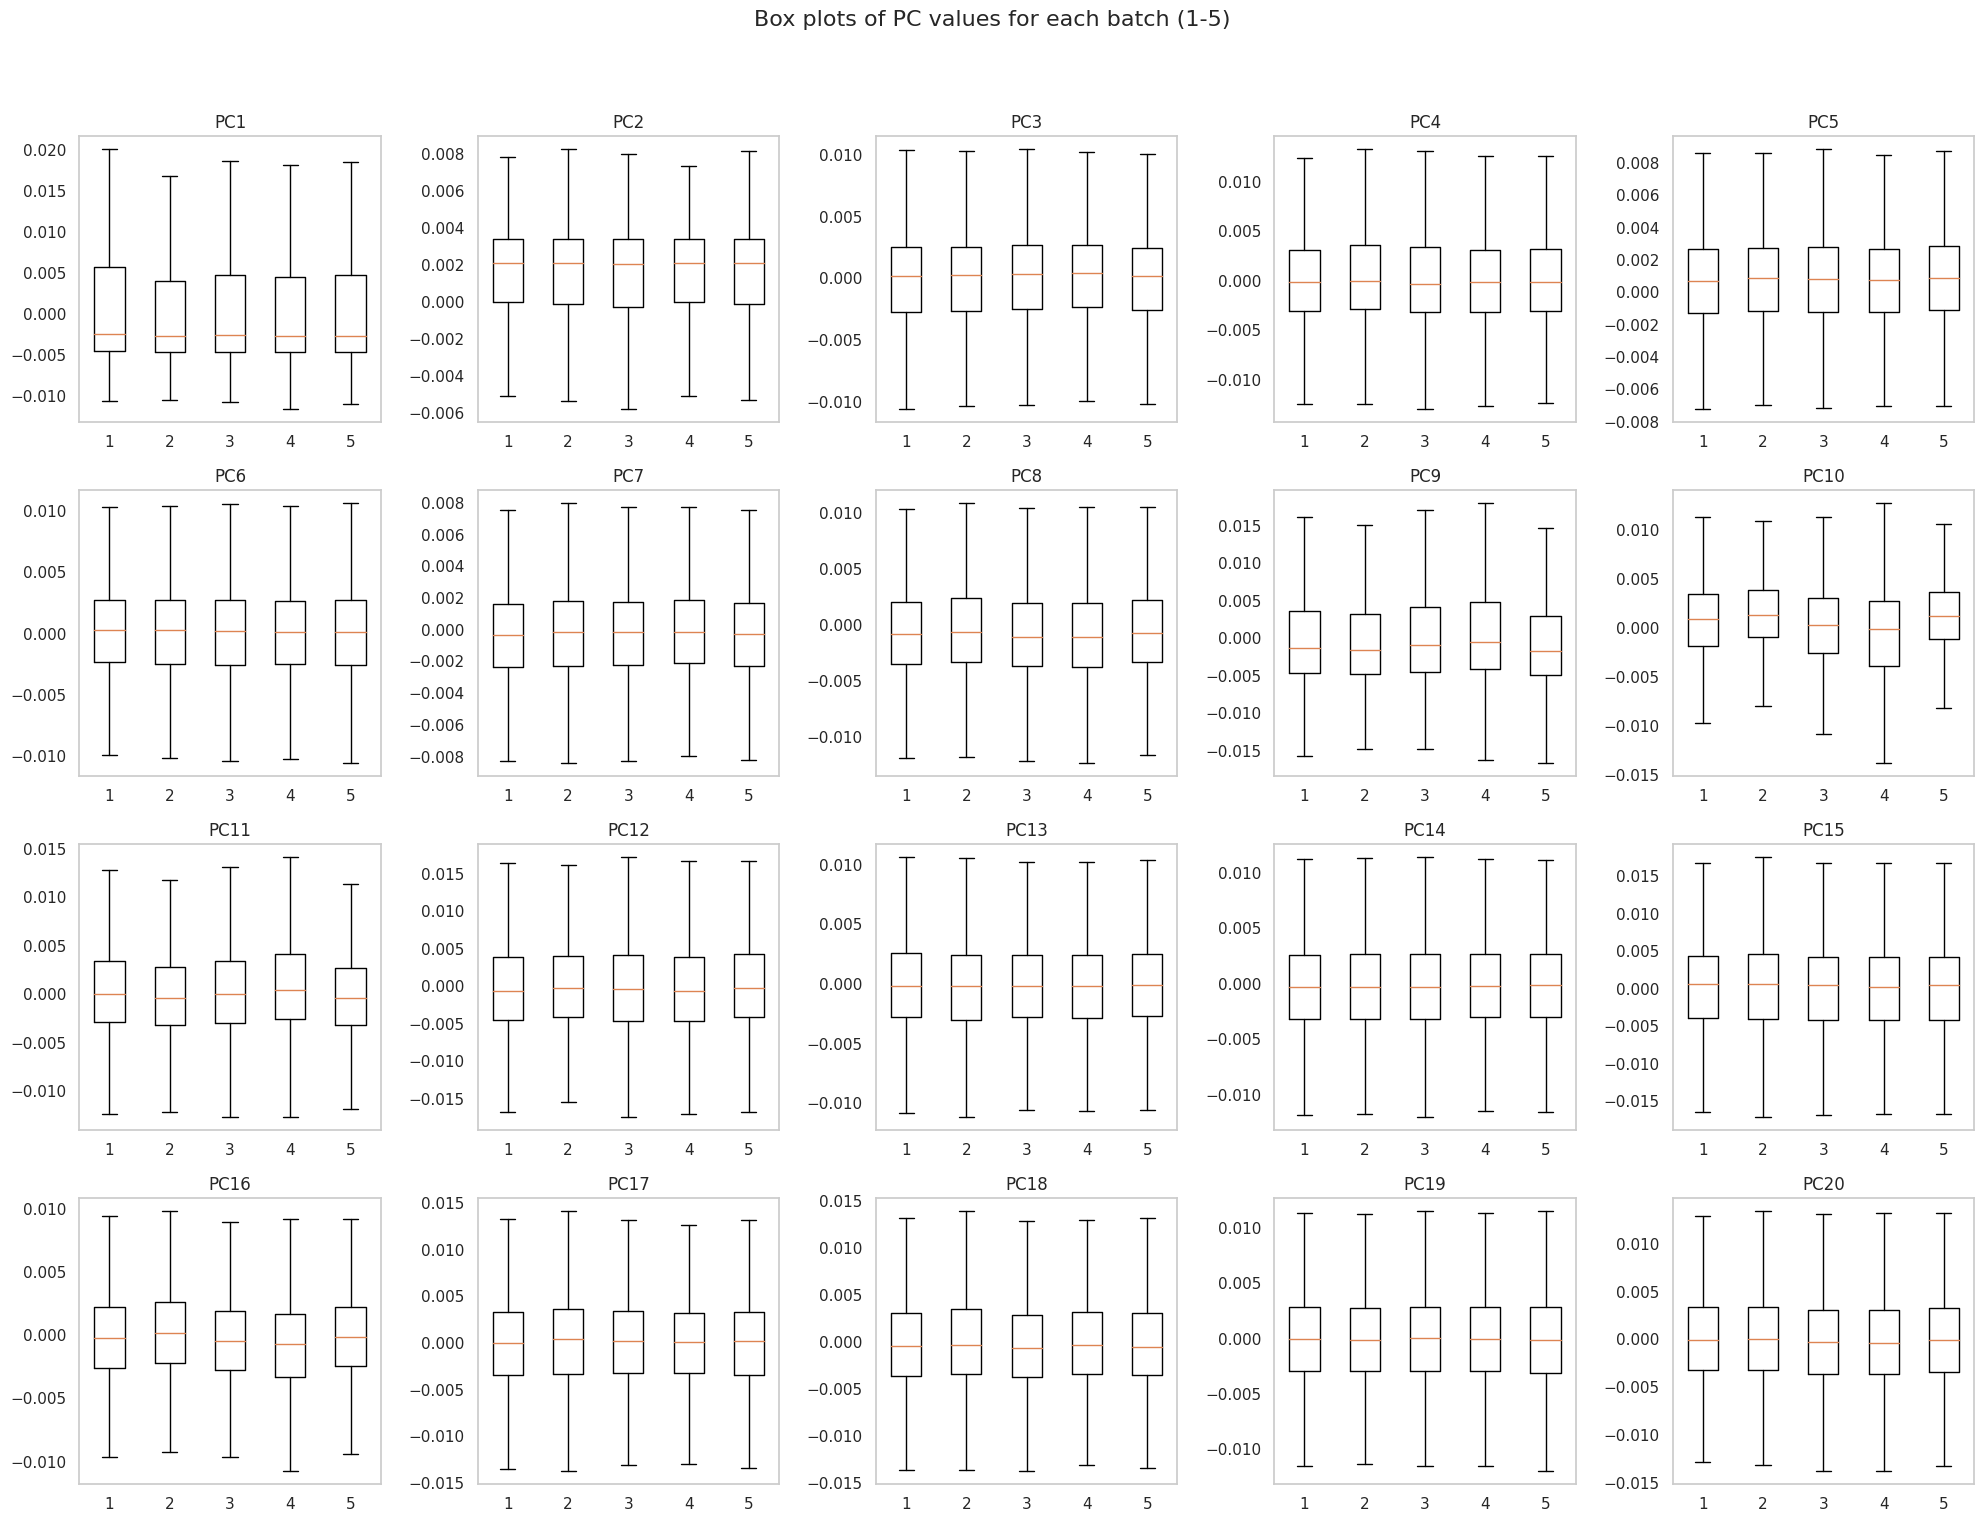

In [15]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming Cov_Regenie is your DataFrame
# First, convert all PC columns to numeric types
for pc in range(1, 21):  # For PC1 to PC20
    Cov_Regenie[f'PC{pc}'] = pd.to_numeric(Cov_Regenie[f'PC{pc}'], errors='coerce')

# Prepare the figure layout
fig, axs = plt.subplots(4, 5, figsize=(20, 16))  # Adjust the figure size as needed
fig.suptitle('Box plots of PC values for each batch (1-5)', fontsize=16)

# Loop over each subplot to create a box plot for each PC
for i in range(1, 21):
    pc_values_for_batches = []
    for batch_number in range(1, 6):  # For each batch
        batch_data = Cov_Regenie[Cov_Regenie['batch'] == batch_number]
        pc_values_for_batches.append(batch_data[f'PC{i}'].dropna())
    
    # Determine the current subplot's position
    row = (i - 1) // 5
    col = (i - 1) % 5
    
    # Plotting in the determined position
    axs[row, col].boxplot(pc_values_for_batches, showfliers=False)
    axs[row, col].set_title(f'PC{i}')
    axs[row, col].set_xticks([1, 2, 3, 4, 5])
    axs[row, col].set_xticklabels(['1', '2', '3', '4', '5'])
    axs[row, col].grid(False)  # Disable the background grid for each subplot

# Adjust layout to prevent overlap
plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust the rect as needed to fit titles and labels
plt.savefig("PC_boxplot_plot_MASTER.png", dpi=300, bbox_inches='tight')
plt.show()


ANOVA test results for PC1: F-value = 2.3519988491145307, p-value = 0.051702761245947304
	There is no statistically significant difference between the means of the batches for PC1.
ANOVA test results for PC2: F-value = 0.4323901019391677, p-value = 0.7853394581342359
	There is no statistically significant difference between the means of the batches for PC2.
ANOVA test results for PC3: F-value = 0.8602724327112986, p-value = 0.4869077065008306
	There is no statistically significant difference between the means of the batches for PC3.
ANOVA test results for PC4: F-value = 3.40917616071067, p-value = 0.008561611032857077
	There is a statistically significant difference between the means of the batches for PC4.
ANOVA test results for PC5: F-value = 1.4191014083894367, p-value = 0.2246883077344064
	There is no statistically significant difference between the means of the batches for PC5.
ANOVA test results for PC6: F-value = 1.1868051465690495, p-value = 0.3142604432319585
	There is no statistically significant difference between the means of the batches for PC6.
ANOVA test results for PC7: F-value = 3.2781255493801553, p-value = 0.010752829911907357
	There is a statistically significant difference between the means of the batches for PC7.
ANOVA test results for PC8: F-value = 6.758647564704659, p-value = 1.9687455632709764e-05
	There is a statistically significant difference between the means of the batches for PC8.
ANOVA test results for PC9: F-value = 35.42325063622635, p-value = 1.493902812250855e-29
	There is a statistically significant difference between the means of the batches for PC9.
ANOVA test results for PC10: F-value = 237.94806739897803, p-value = 7.877855277426742e-201
	There is a statistically significant difference between the means of the batches for PC10.
ANOVA test results for PC11: F-value = 26.546847145148025, p-value = 5.282387088100409e-22
	There is a statistically significant difference between the means of the batches for PC11.
ANOVA test results for PC12: F-value = 4.647112185838704, p-value = 0.0009492844567861051
	There is a statistically significant difference between the means of the batches for PC12.
ANOVA test results for PC13: F-value = 2.689637607746729, p-value = 0.029439729262406348
	There is a statistically significant difference between the means of the batches for PC13.
ANOVA test results for PC14: F-value = 0.3246100237962921, p-value = 0.861636984506272
	There is no statistically significant difference between the means of the batches for PC14.
ANOVA test results for PC15: F-value = 5.9297725639703955, p-value = 9.136810586394117e-05
	There is a statistically significant difference between the means of the batches for PC15.
ANOVA test results for PC16: F-value = 112.28276126048887, p-value = 5.023498611922456e-95
	There is a statistically significant difference between the means of the batches for PC16.
ANOVA test results for PC17: F-value = 2.565564079857158, p-value = 0.03626052772120057
	There is a statistically significant difference between the means of the batches for PC17.
ANOVA test results for PC18: F-value = 3.5061168008517467, p-value = 0.007228247835773781
	There is a statistically significant difference between the means of the batches for PC18.
ANOVA test results for PC19: F-value = 0.5439327319349923, p-value = 0.7034762266710815
	There is no statistically significant difference between the means of the batches for PC19.
ANOVA test results for PC20: F-value = 4.724979323539337, p-value = 0.00082476270698485
	There is a statistically significant difference between the means of the batches for PC20.
